In [0]:
import csv
import nltk
from sklearn.metrics import confusion_matrix
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import *
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn import linear_model
from sklearn.metrics import *

In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
data=pd.read_csv('/content/gdrive/My Drive/precily/data_t.csv')

In [0]:
data.head()

,Unnamed: 0,Unnamed: 0.1,link,title,description,catagory
0,0,0,FGe3KhkNx,Mouthwatering INDIAN STREET FOOD Breakfast Tou...,Subscribe to my channel ► http://bit.ly/DBH-SU...,Food
1,1,1,0SPwwpruGIA,42 Foods You Need To Eat Before You Die | The ...,This is the ultimate must-try food bucket list...,Food
2,2,2,XwHurP9RH-,42 Cheesy Foods You Need To Eat Before You Die...,"From pizza pot pies to cheeseburger dumplings,...",Food
3,3,3,M0OC-rYVvy8,CHOOSE THE BOWL CHALLENGE | Bowl Challenge | B...,Download Azar and make new friends: https://bi...,Food
4,4,4,T6pwKbBcS8U,Phuket Food | Luxury Resort,"Buffet for Breakfast, Veg Pizza for Lunch and ...",Food


##Cleaning the data and Preprocessing

In [0]:
data1=data.iloc[:,1:]

In [0]:
data1.head()

,Unnamed: 0.1,link,title,description,catagory
0,0,FGe3KhkNx,Mouthwatering INDIAN STREET FOOD Breakfast Tou...,Subscribe to my channel ► http://bit.ly/DBH-SU...,Food
1,1,0SPwwpruGIA,42 Foods You Need To Eat Before You Die | The ...,This is the ultimate must-try food bucket list...,Food
2,2,XwHurP9RH-,42 Cheesy Foods You Need To Eat Before You Die...,"From pizza pot pies to cheeseburger dumplings,...",Food
3,3,M0OC-rYVvy8,CHOOSE THE BOWL CHALLENGE | Bowl Challenge | B...,Download Azar and make new friends: https://bi...,Food
4,4,T6pwKbBcS8U,Phuket Food | Luxury Resort,"Buffet for Breakfast, Veg Pizza for Lunch and ...",Food


In [0]:
data1.dtypes

Unnamed: 0.1     int64
link            object
title           object
description     object
catagory        object
dtype: object

In [0]:
data1= data1[data1['description'].notnull()]

In [0]:
data1.shape

(7057, 5)

In [0]:
# removing punctiuations
data1['title'] = data1['title'].str.replace('[^\w\s]','')
data1['title'].head()

0    Mouthwatering INDIAN STREET FOOD Breakfast Tou...
1    42 Foods You Need To Eat Before You Die  The U...
2    42 Cheesy Foods You Need To Eat Before You Die...
3    CHOOSE THE BOWL CHALLENGE  Bowl Challenge  Bro...
4                           Phuket Food  Luxury Resort
Name: title, dtype: object

In [0]:
data1['description'] = data1['description'].str.replace('[^\w\s]','')
data1['description'].head()

0    Subscribe to my channel  httpbitlyDBHSUB \nChe...
1    This is the ultimate musttry food bucket list ...
2    From pizza pot pies to cheeseburger dumplings ...
3    Download Azar and make new friends httpsbitly2...
4    Buffet for Breakfast Veg Pizza for Lunch and T...
Name: description, dtype: object

In [0]:
#making_lowercase
#join return the str which is connected by " "
data1['title'] = data1['title'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data1['title'].head()


0    mouthwatering indian street food breakfast tou...
1    42 foods you need to eat before you die the ul...
2    42 cheesy foods you need to eat before you die...
3    choose the bowl challenge bowl challenge broth...
4                            phuket food luxury resort
Name: title, dtype: object

In [0]:
data1['description'] = data1['description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
data1['description'].head()


0    subscribe to my channel httpbitlydbhsub check ...
1    this is the ultimate musttry food bucket list ...
2    from pizza pot pies to cheeseburger dumplings ...
3    download azar and make new friends httpsbitly2...
4    buffet for breakfast veg pizza for lunch and t...
Name: description, dtype: object

In [0]:
#stop word removal
import nltk
nltk.download('stopwords')
  

from nltk.corpus import stopwords
stop = stopwords.words('english')
data1['title'] = data1['title'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data1['title'].head()




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    mouthwatering indian street food breakfast tou...
1                  42 foods need eat die ultimate list
2           42 cheesy foods need eat die ultimate list
3    choose bowl challenge bowl challenge brother v...
4                            phuket food luxury resort
Name: title, dtype: object

In [0]:
#same for description column
stop = stopwords.words('english')
data1['description'] = data1['description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
data1['description'].head()

0    subscribe channel httpbitlydbhsub check blog h...
1    ultimate musttry food bucket list burgers dipp...
2    pizza pot pies cheeseburger dumplings 42 chees...
3    download azar make new friends httpsbitly2vyth...
4    buffet breakfast veg pizza lunch thailand stre...
Name: description, dtype: object

In [0]:
#stemming
from nltk.stem import PorterStemmer
st = PorterStemmer()
data1['title'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
data1['title'].head()

0    mouthwatering indian street food breakfast tou...
1                  42 foods need eat die ultimate list
2           42 cheesy foods need eat die ultimate list
3    choose bowl challenge bowl challenge brother v...
4                            phuket food luxury resort
Name: title, dtype: object

In [0]:
data1['description'].apply(lambda x: " ".join([st.stem(word) for word in x.split()]))
data1['description'].head()

0    subscribe channel httpbitlydbhsub check blog h...
1    ultimate musttry food bucket list burgers dipp...
2    pizza pot pies cheeseburger dumplings 42 chees...
3    download azar make new friends httpsbitly2vyth...
4    buffet breakfast veg pizza lunch thailand stre...
Name: description, dtype: object

In [0]:
data2=data1.iloc[:,1:]
data2.head()

,link,title,description,catagory
0,FGe3KhkNx,mouthwatering indian street food breakfast tou...,subscribe channel httpbitlydbhsub check blog h...,Food
1,0SPwwpruGIA,42 foods need eat die ultimate list,ultimate musttry food bucket list burgers dipp...,Food
2,XwHurP9RH-,42 cheesy foods need eat die ultimate list,pizza pot pies cheeseburger dumplings 42 chees...,Food
3,M0OC-rYVvy8,choose bowl challenge bowl challenge brother v...,download azar make new friends httpsbitly2vyth...,Food
4,T6pwKbBcS8U,phuket food luxury resort,buffet breakfast veg pizza lunch thailand stre...,Food


In [0]:
#reshuffling the data so that our model can not learn based on the catagory pattern
data2=data2.sample(frac=1).reset_index(drop=True)
data2.head()

,link,title,description,catagory
0,znqkM9Ttom4,hollow metal doors manufacturing process,explains make hollow metal doors start finish ...,Manufacturing
1,V_Rw8hyWI,2019 honda accord manufacturing honda accord 2...,2019 honda accord manufacturing honda accord 2...,Manufacturing
2,fYezB4eY,amazing arts crafts,amazing arts crafts blow mind amazing videos s...,Arts and Music
3,j7B8ChO8XeE,introduction ibm watson studio previously call...,ready dip toes data science pool see ibm watso...,Science and Technology
4,dpa2Z-cRowU,traveling alone first time,stay tuned part 2 hehe hannah meloche instagra...,travel


In [0]:
df_category = pd.DataFrame(columns = ["encode"])     
df_category['encode'] = data2['catagory']

In [0]:
#label encoder
from sklearn.preprocessing import LabelEncoder
dfcategory = df_category.apply(LabelEncoder().fit_transform)

In [0]:
dfcategory.head()

,encode
0,3
1,3
2,0
3,4
4,5


In [0]:
data2.head()

,link,title,description,catagory
0,znqkM9Ttom4,hollow metal doors manufacturing process,explains make hollow metal doors start finish ...,Manufacturing
1,V_Rw8hyWI,2019 honda accord manufacturing honda accord 2...,2019 honda accord manufacturing honda accord 2...,Manufacturing
2,fYezB4eY,amazing arts crafts,amazing arts crafts blow mind amazing videos s...,Arts and Music
3,j7B8ChO8XeE,introduction ibm watson studio previously call...,ready dip toes data science pool see ibm watso...,Science and Technology
4,dpa2Z-cRowU,traveling alone first time,stay tuned part 2 hehe hannah meloche instagra...,travel


In [0]:
#adding Enoding column
data3=pd.concat([data2,dfcategory], axis=1, join_axes = [data2.index])
data3.head()

,link,title,description,catagory,encode
0,znqkM9Ttom4,hollow metal doors manufacturing process,explains make hollow metal doors start finish ...,Manufacturing,3
1,V_Rw8hyWI,2019 honda accord manufacturing honda accord 2...,2019 honda accord manufacturing honda accord 2...,Manufacturing,3
2,fYezB4eY,amazing arts crafts,amazing arts crafts blow mind amazing videos s...,Arts and Music,0
3,j7B8ChO8XeE,introduction ibm watson studio previously call...,ready dip toes data science pool see ibm watso...,Science and Technology,4
4,dpa2Z-cRowU,traveling alone first time,stay tuned part 2 hehe hannah meloche instagra...,travel,5


In [0]:
#Bag of Words
from sklearn.feature_extraction.text import CountVectorizer   
cv = CountVectorizer(max_features = 2000) 
X = cv.fit_transform(data2.title,data2.description).toarray() 
Y = data3.iloc[:,4].values

In [0]:
X.shape
Y.shape

(7057,)

In [0]:
from sklearn.preprocessing import label_binarize

# Use label_binarize to be multi-label like settings
Y = label_binarize(y, classes=[0, 1, 2,3,4,5])
n_classes = Y.shape[1]

In [0]:
#splittig test train data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.20, random_state = 0)

##Classification using SVM

In [0]:
from sklearn.svm import SVC
model_svm= SVC(kernel = 'linear', random_state = 0)
model_svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=0,
    shrinking=True, tol=0.001, verbose=False)

In [0]:
y_pred = model_svm.predict(X_test)

In [0]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96       121
           1       0.95      0.98      0.97       411
           2       0.95      0.97      0.96        60
           3       0.99      0.99      0.99       288
           4       0.99      0.97      0.98       332
           5       0.95      0.96      0.96       200

    accuracy                           0.97      1412
   macro avg       0.97      0.97      0.97      1412
weighted avg       0.97      0.97      0.97      1412



So, here we can see each value for different target labels  all are above 90 % which is good.

In [0]:
model_svm.score(X_test, y_test)

0.9723796033994334

In [0]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       121
           1       0.99      0.95      0.97       411
           2       0.97      0.97      0.97        60
           3       0.90      1.00      0.94       288
           4       0.99      0.95      0.97       332
           5       0.96      0.96      0.96       200

    accuracy                           0.96      1412
   macro avg       0.97      0.96      0.96      1412
weighted avg       0.97      0.96      0.96      1412



##Classification using Xgboost

In [0]:
from xgboost import XGBClassifier
model_boost = XGBClassifier()
model_boost.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
y_pred = model_boost.predict(X_test)

In [0]:
model_boost.score(X_test, y_test)

0.9631728045325779

In [0]:
 print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97       121
           1       0.99      0.95      0.97       411
           2       0.97      0.97      0.97        60
           3       0.90      1.00      0.94       288
           4       0.99      0.95      0.97       332
           5       0.96      0.96      0.96       200

    accuracy                           0.96      1412
   macro avg       0.97      0.96      0.96      1412
weighted avg       0.97      0.96      0.96      1412



In [234]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i] = precision_recall_curve(y_test[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

IndexError: ignored


##Clasification using  LSTM

In [0]:
#making two text column as one input column

data3['combined'] = data3[['title', 'description']].apply(lambda x: ' '.join(x), axis=1)
#y = data3["encode"].values
#list_sentences_train = train["comment_text"]
#list_sentences_test = test["comment_text"]
data3.head()

,link,title,description,catagory,encode,combined
0,znqkM9Ttom4,hollow metal doors manufacturing process,explains make hollow metal doors start finish ...,Manufacturing,3,hollow metal doors manufacturing process expla...
1,V_Rw8hyWI,2019 honda accord manufacturing honda accord 2...,2019 honda accord manufacturing honda accord 2...,Manufacturing,3,2019 honda accord manufacturing honda accord 2...
2,fYezB4eY,amazing arts crafts,amazing arts crafts blow mind amazing videos s...,Arts and Music,0,amazing arts crafts amazing arts crafts blow m...
3,j7B8ChO8XeE,introduction ibm watson studio previously call...,ready dip toes data science pool see ibm watso...,Science and Technology,4,introduction ibm watson studio previously call...
4,dpa2Z-cRowU,traveling alone first time,stay tuned part 2 hehe hannah meloche instagra...,travel,5,traveling alone first time stay tuned part 2 h...


In [0]:
one_hot= pd.get_dummies(data3.catagory)
one_hot.head()

,Arts and Music,Food,History,Manufacturing,Science and Technology,travel
0,0,0,0,1,0,0
1,0,0,0,1,0,0
2,1,0,0,0,0,0
3,0,0,0,0,1,0
4,0,0,0,0,0,1


In [0]:
data3=pd.concat([data3,one_hot], axis=1, join_axes = [data2.index])
data3.head()
#y = data3["encode"].values
#list_sentences_train = data3["combined"]
#list_sentences_test = test["comment_text"]

,link,title,description,catagory,encode,combined,Arts and Music,Food,History,Manufacturing,Science and Technology,travel
0,znqkM9Ttom4,hollow metal doors manufacturing process,explains make hollow metal doors start finish ...,Manufacturing,3,hollow metal doors manufacturing process expla...,0,0,0,1,0,0
1,V_Rw8hyWI,2019 honda accord manufacturing honda accord 2...,2019 honda accord manufacturing honda accord 2...,Manufacturing,3,2019 honda accord manufacturing honda accord 2...,0,0,0,1,0,0
2,fYezB4eY,amazing arts crafts,amazing arts crafts blow mind amazing videos s...,Arts and Music,0,amazing arts crafts amazing arts crafts blow m...,1,0,0,0,0,0
3,j7B8ChO8XeE,introduction ibm watson studio previously call...,ready dip toes data science pool see ibm watso...,Science and Technology,4,introduction ibm watson studio previously call...,0,0,0,0,1,0
4,dpa2Z-cRowU,traveling alone first time,stay tuned part 2 hehe hannah meloche instagra...,travel,5,traveling alone first time stay tuned part 2 h...,0,0,0,0,0,1


In [0]:
list_classes = ["Arts and Music", "Food", "History", "Manufacturing", "Science and Technology","travel"]
y = data3[list_classes].values
list_sentences_train = data3["combined"]

In [0]:
max_features = 20000
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
#list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

In [0]:
maxlen = 200
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
#X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

In [0]:
list_tokenized_train[:1]

[[5222,
  1277,
  3417,
  23,
  54,
  1591,
  24,
  5222,
  1277,
  3417,
  162,
  2230,
  451,
  280,
  23,
  54,
  17074]]

In [0]:
inp = Input(shape=(maxlen, ))

In [0]:
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

In [0]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

In [0]:
x = GlobalMaxPool1D()(x)

In [0]:
x = Dropout(0.1)(x)

In [0]:
x = Dense(50, activation="relu")(x)

In [0]:
x = Dropout(0.1)(x)

In [0]:
x = Dense(6, activation="sigmoid")(x)

In [0]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [0]:
batch_size = 32
epochs = 8
history=model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.3)


Train on 4939 samples, validate on 2118 samples
Epoch 1/8
4939/4939 [==============================] - 50s 10ms/step - loss: 0.4586 - acc: 0.7978 - val_loss: 0.3476 - val_acc: 0.8608
Epoch 2/8
4939/4939 [==============================] - 49s 10ms/step - loss: 0.2506 - acc: 0.9025 - val_loss: 0.1547 - val_acc: 0.9503
Epoch 3/8
4939/4939 [==============================] - 49s 10ms/step - loss: 0.1103 - acc: 0.9656 - val_loss: 0.0783 - val_acc: 0.9742
Epoch 4/8
4939/4939 [==============================] - 49s 10ms/step - loss: 0.0495 - acc: 0.9853 - val_loss: 0.0534 - val_acc: 0.9847
Epoch 5/8
4939/4939 [==============================] - 49s 10ms/step - loss: 0.0276 - acc: 0.9931 - val_loss: 0.0460 - val_acc: 0.9862
Epoch 6/8
4939/4939 [==============================] - 49s 10ms/step - loss: 0.0250 - acc: 0.9928 - val_loss: 0.0410 - val_acc: 0.9878
Epoch 7/8
4939/4939 [==============================] - 49s 10ms/step - loss: 0.0137 - acc: 0.9964 - val_loss: 0.0400 - val_acc: 0.9884
Epoch 8

So here we can see that when  we use LSTM we are getting very high accuracythan the other two non neural network algorithms.

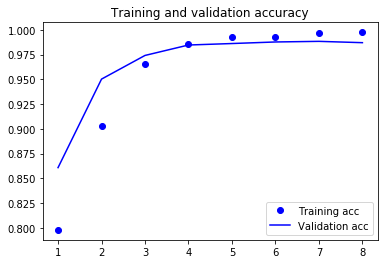

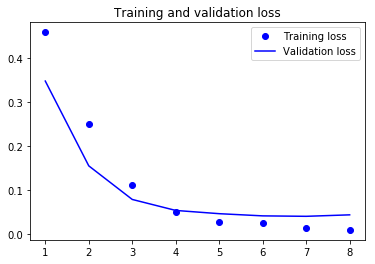

In [0]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

trainig and validation set both are approching same amount of accuracy and error so no chance of over fitting and under fitting.